# Тестовое задание

Импорт библиотек для работы:

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Изучение данных и их предобработка

Читаем данные:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/aemcx_test_task/Тестовое задание.csv', sep=r';', quotechar='"')

Выведем 5 строк:

In [ ]:
df.head()

,classification,year,period,period_desc,aggregate_level,is_leaf_code,trade_flow_code,trade_flow,reporter_code,reporter,reporter_iso,partner_code,partner,commodity_code,commodity,qty_unit_code,qty_unit,qty,alt_qty_unit_code,alt_qty_unit,alt_qty,netweight,gross_weight,trade_value,cif_trade_value,fob_trade_value,flag
0,HS,2019,01.01.2019,January 2019,6,1,1,Import,24,Angola,NaN,0,World,220890,"Spirits, liqueurs and other spirituous beverag...",0,No Quantity,NaN,NaN,0,NaN,27278,NaN,36118,NaN,NaN,0
1,HS,2019,01.01.2019,January 2019,4,0,1,Import,24,Angola,NaN,0,World,2209,Vinegar and substitutes for vinegar obtained f...,0,No Quantity,NaN,NaN,0,NaN,414325,NaN,304413,NaN,NaN,0
2,HS,2019,01.01.2019,January 2019,6,1,1,Import,24,Angola,NaN,0,World,220900,Vinegar and substitutes for vinegar; obtained ...,0,No Quantity,NaN,NaN,0,NaN,414325,NaN,304413,NaN,NaN,0
3,HS,2019,01.01.2019,January 2019,2,0,1,Import,24,Angola,NaN,0,World,23,"Food industries, residues and wastes thereof; ...",0,No Quantity,NaN,NaN,0,NaN,0,NaN,3246185,NaN,NaN,0
4,HS,2019,01.01.2019,January 2019,4,0,1,Import,24,Angola,NaN,0,World,2302,"Bran, sharps and other residues; whether or no...",0,No Quantity,NaN,NaN,0,NaN,809,NaN,512,NaN,NaN,0


Посмотрим информацию о пропущенных значениях, и типах данных:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513266 entries, 0 to 513265
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   classification     513266 non-null  object 
 1   year               513266 non-null  int64  
 2   period             513266 non-null  object 
 3   period_desc        513266 non-null  object 
 4   aggregate_level    513266 non-null  int64  
 5   is_leaf_code       513266 non-null  int64  
 6   trade_flow_code    513266 non-null  int64  
 7   trade_flow         513266 non-null  object 
 8   reporter_code      513266 non-null  int64  
 9   reporter           513266 non-null  object 
 10  reporter_iso       0 non-null       float64
 11  partner_code       513266 non-null  int64  
 12  partner            513266 non-null  object 
 13  commodity_code     513266 non-null  object 
 14  commodity          513266 non-null  object 
 15  qty_unit_code      513266 non-null  int64  
 16  qt

Удалим столбцы в которых пустые значения:

In [ ]:
df = df.dropna(axis=1, how='all')

Удалим столбцы в которых только одно значение:

In [ ]:
for i in list(df.columns):
  if len(df[i].unique()) == 1:
    df = df.drop(columns=[i], axis = 1)

Приведем тип данных для столбца `period` к датам, и удалим дублирующий столбец с периодом `period_desc`:

In [ ]:
df['period'] = pd.to_datetime(df['period'], format='%d.%m.%Y')
df = df.drop(columns=['period_desc', 'year'], axis = 1)

Удалим знаки ',' и ';' в столбце `commodity` для снижения ошибок при работке с *.csv:

In [ ]:
df['commodity'] = df['commodity'].replace(to_replace=r';', value='', regex=True)
df['commodity'] = df['commodity'].replace(to_replace=r',', value='', regex=True)

Выведем информацию о получившийся таблице:

In [ ]:
df.head()

,period,aggregate_level,is_leaf_code,trade_flow_code,trade_flow,reporter_code,reporter,partner_code,partner,commodity_code,commodity,netweight,trade_value
0,2019-01-01,6,1,1,Import,24,Angola,0,World,220890,Spirits liqueurs and other spirituous beverage...,27278,36118
1,2019-01-01,4,0,1,Import,24,Angola,0,World,2209,Vinegar and substitutes for vinegar obtained f...,414325,304413
2,2019-01-01,6,1,1,Import,24,Angola,0,World,220900,Vinegar and substitutes for vinegar obtained f...,414325,304413
3,2019-01-01,2,0,1,Import,24,Angola,0,World,23,Food industries residues and wastes thereof pr...,0,3246185
4,2019-01-01,4,0,1,Import,24,Angola,0,World,2302,Bran sharps and other residues whether or not ...,809,512


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513266 entries, 0 to 513265
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   period           513266 non-null  datetime64[ns]
 1   aggregate_level  513266 non-null  int64         
 2   is_leaf_code     513266 non-null  int64         
 3   trade_flow_code  513266 non-null  int64         
 4   trade_flow       513266 non-null  object        
 5   reporter_code    513266 non-null  int64         
 6   reporter         513266 non-null  object        
 7   partner_code     513266 non-null  int64         
 8   partner          513266 non-null  object        
 9   commodity_code   513266 non-null  object        
 10  commodity        513266 non-null  object        
 11  netweight        513266 non-null  int64         
 12  trade_value      513266 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 50.9+ MB


Сохраним обработанный датасет:

Для БД Postgresql создадим несколько *.csv для подгрузки в нее (основные данные, справочники: типы продаж, поставщик, партнер, расшифорвка ТНВЭД):

In [ ]:
table_main = df.drop(columns=['trade_flow', 'reporter', 'partner', 'commodity'], axis = 1)
table_main['year_n'] = table_main['period'].dt.year
table_main['month_n'] = table_main['period'].dt.month
table_main = table_main.drop(columns=['period'], axis = 1)

table_trade_flow = df[['trade_flow', 'trade_flow_code']].drop_duplicates()
table_reporter = df[['reporter', 'reporter_code']].drop_duplicates()
table_partner = df[['partner', 'partner_code']].drop_duplicates()
table_commodity = df[['commodity', 'commodity_code']].drop_duplicates()

In [ ]:
#table_main.to_csv('/content/drive/MyDrive/aemcx_test_task/table_main.csv', index=False)
#table_trade_flow.to_csv('/content/drive/MyDrive/aemcx_test_task/table_trade_flow.csv', index=False)
#table_reporter.to_csv('/content/drive/MyDrive/aemcx_test_task/table_reporter.csv', index=False)
#table_partner.to_csv('/content/drive/MyDrive/aemcx_test_task/table_partner.csv', index=False)
#table_commodity.to_csv('/content/drive/MyDrive/aemcx_test_task/table_commodity.csv', index=False)

Создание в БД таблиц:

CREATE TABLE table_main  
(	
	id SERIAL PRIMARY KEY,  
	aggregate_level int,  
	is_leaf_code int,  
	trade_flow_code int,  
	reporter_code int,  
	partner_code int,  
	commodity_code VARCHAR(40),  
	netweight DECIMAL(20, 2),  
	trade_value DECIMAL(20, 2),  
	year_n int,  
	month_n int  
);    


CREATE TABLE table_trade_flow (trade_flow_code INT, trade_flow VARCHAR(100));  
CREATE TABLE table_reporter(reporter_code INT, reporter VARCHAR(100));  
CREATE TABLE table_partner(partner_code INT, partner VARCHAR(100));  
CREATE TABLE table_commodity(commodity_code VARCHAR(30), commodity VARCHAR(350));

`Загрузку *.csv выполним через IDE. Создадим связи.`

Получившиеся диаграмма БД:

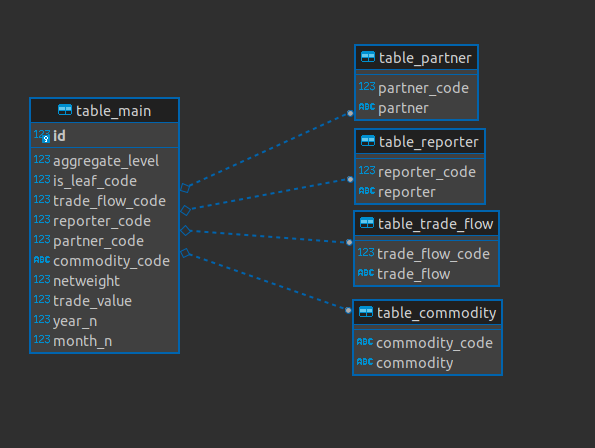

### Вывод

Провели предобратоку данных, удалили лишние столбцы.
Возможно в дальнешей потребуется изучить значения в столбцах.
Создали БД.

## Ответы на вопросы

### Объем импорта мяса птицы Анголой в 2019 году  

Примечание: ТН ВЭД	0207	Мясо и пищевые субпродукты домашней птицы, указанной в товарной позиции 0105, свежие, охлажденные или замороженные

Выведем суммарную стоимость мяса птицы (не живой) в долларах США импортированной Ангологой в 2019:

In [ ]:
df_bird_angola = df[(df['commodity_code'].str.startswith('0207')) & (df['reporter'] == 'Angola') & (df['trade_flow'] == 'Import')]

In [ ]:
df_bird_angola['trade_value'].sum()

790508582

Решение на SQL:

SELECT SUM(trade_value)  
FROM table_main tm   
WHERE commodity_code like '0207%' AND reporter_code = '24' AND trade_flow_code = '1';

### Cтрана, поставившая в Анголу наибольший объем мяса птицы в стоимостном выражении в марте 2019 года

Проведем группировку данных с учетом требований вопроса:

In [ ]:
df_bird_angola[df_bird_angola['period'].dt.month == 3].pivot_table(values='trade_value', index='partner', aggfunc='sum').sort_values(by='trade_value', ascending=False).reset_index().head()

,partner,trade_value
0,World,32944663
1,United States of America,19015178
2,Brazil,5632528
3,Portugal,1978442
4,France,1539382


Решение на SQL:

SELECT tp.partner AS "Поставщик", sum(trade_value) AS "Суммарная стоимость"  
FROM table_main tm   
JOIN table_partner tp ON tp.partner_code = tm.partner_code  
WHERE tm.commodity_code LIKE '0207%' AND tm.reporter_code = '24' AND tm.trade_flow_code = '1' AND tm.month_n = 3  
GROUP BY tp.partner  
ORDER BY 2 DESC;

### Структуру импорта мяса птицы Анголой по странам поставщикам по весу

Сгруппируем данные, а также создадим столбец `mean` со средним значением доли импорта в %:

In [ ]:
df_bird_angola_county = df_bird_angola.pivot_table(values='trade_value', index='partner', aggfunc='sum').reset_index()
df_bird_angola_county['mean'] = round(df_bird_angola_county['trade_value'] / df_bird_angola_county['trade_value'].sum(), 4) * 100

In [ ]:
df_bird_angola_county.sort_values(by='mean', ascending=False).head(10)

,partner,trade_value,mean
35,World,395254284,50.00
33,United States of America,231631336,29.30
3,Brazil,86749146,10.97
29,Turkey,16115965,2.04
0,Argentina,13588876,1.72
11,France,8751768,1.11
25,Portugal,8137198,1.03
2,Belgium,5693172,0.72
32,United Kingdom,5476440,0.69
17,Italy,4014726,0.51


Решение SQL:

SELECT   
	tp.partner AS "Поставщик",   
	SUM(trade_value) AS "Суммарная стоимость",  
	ROUND(SUM(trade_value) / SUM(SUM(trade_value)) OVER () * 100, 2) AS "Доля"  
FROM table_main tm   
JOIN table_partner tp ON tp.partner_code = tm.partner_code  
WHERE tm.commodity_code LIKE '0207%' AND tm.reporter_code = '24' AND tm.trade_flow_code = '1' AND tm.month_n = 3  
GROUP BY tp.partner  
ORDER BY 2 DESC;  

### Динамика средневзвешенной цены закупаемой Анголой мяса птицы по месяцам

Для построения гистограммы создадим столбец с месяцами, а также проведем группировку с создадием столбца со средним значениями:

In [ ]:
df_bird_angola['month'] = df_bird_angola['period'].dt.month
df_bird_angola_fig = df_bird_angola.pivot_table(values='trade_value', index='month', aggfunc='mean').reset_index()

Вывдем первые пять строк:

In [ ]:
df_bird_angola_fig.head()

,month,trade_value
0,1,1.264891e+06
1,2,1.483365e+06
2,3,1.062731e+06
3,4,1.189669e+06
4,5,8.004174e+05


Нарисуем гистрограмму:

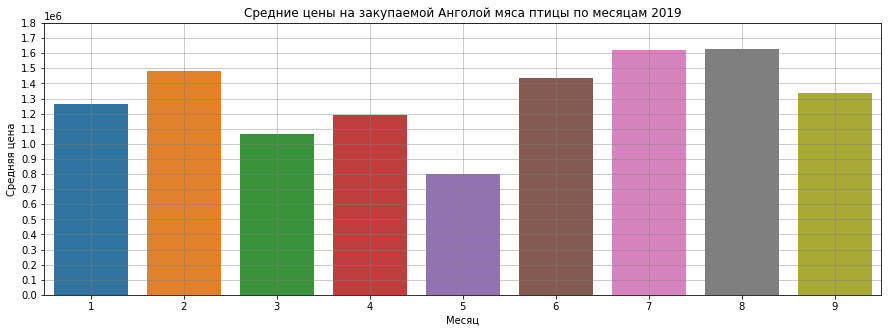

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(data=df_bird_angola_fig, x=df_bird_angola_fig['month'], y="trade_value")
plt.title('Средние цены на закупаемой Анголой мяса птицы по месяцам 2019')
plt.ylabel('Средняя цена')
plt.xlabel('Месяц')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.yticks(np.arange(0, 1900000, 100000))
plt.show()

### Объем поставок в стоимостном выражении продукции из Российской Федерации в первом полугодии

Определим объем поставок в стоимостном выражении продукции, первые два символа ТН ВЭД которой входят в интервал от 01 до 24 включительно, в Анголу и Антигуа и Барбуда из Российской Федерации в первом полугодии 2019 года.

Выполним группировку, а также пройдемся циклом с целью выбрать первые два символа кода ТН ВЭД с диапазоном с 01 до 24:

In [ ]:
df_from_russia = df[(df['commodity_code'].str.startswith(f"01")) & (df['partner'] == 'Russian Federation')]
for i in range(2, 25):
  df_from_russia_i = df[(df['commodity_code'].str.startswith(f"{i:02d}")) & (df['partner'] == 'Russian Federation')]
  df_from_russia = pd.concat([df_from_russia, df_from_russia_i], ignore_index=True)
df_from_russia['month'] = df_from_russia['period'].dt.month
df_from_russia = df_from_russia[df_from_russia['month'] <= 6]

Посмотрим на таблицу:

In [ ]:
df_from_russia.head()

,period,aggregate_level,is_leaf_code,trade_flow_code,trade_flow,reporter_code,reporter,partner_code,partner,commodity_code,commodity,netweight,trade_value,month
0,2019-02-01,2,0,1,Import,24,Angola,643,Russian Federation,01,Animals live,0,1204,2
1,2019-02-01,4,0,1,Import,24,Angola,643,Russian Federation,0106,Animals n.e.s. in chapter 01 live,20,1204,2
2,2019-02-01,6,1,1,Import,24,Angola,643,Russian Federation,010619,Mammals live other than primates whales dolphi...,20,1204,2
3,2019-01-01,2,0,1,Import,24,Angola,643,Russian Federation,02,Meat and edible meat offal,0,255872,1
4,2019-01-01,4,0,1,Import,24,Angola,643,Russian Federation,0202,Meat of bovine animals frozen,13578,71834,1


Агрегируем данные и выведем таблицу со стоимостном выражении продукции из РФ:

In [ ]:
df_from_russia_group = df_from_russia.pivot_table(values='trade_value', index='month', aggfunc='sum').reset_index()

In [ ]:
df_from_russia_group

,month,trade_value
0,1,767616
1,2,3612
2,4,889839
3,5,387
4,6,110019


## Вывод

- наибольшее количество мясо птицы в марте 2019 года в Анголу поставляла США и Бразилия (19015178 и 5632528 в долларах США соотвественно);
- за 2019 год в Анголу поставки распределены в целом равномерно, но наблюдается небольшой спад к лету;
- наиболелье количество продукции из РФ поставлено в апреле 2019 года.